<a href="https://colab.research.google.com/github/Maansi-1590/Shopper_Spectrum/blob/main/Shopper_Spectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()  # Choose the file from your system when prompted

import pandas as pd
df = pd.read_csv(list(uploaded.keys())[0])
df.head()

Saving online_retail.csv to online_retail.csv


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
print(df.shape)

(541909, 8)


In [ ]:
print(df.head)

<bound method NDFrame.head of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

                InvoiceDate  UnitPrice  Custo

In [ ]:
# Remove missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove cancelled invoices
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative or zero quantities/prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Compute total purchase amount
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [ ]:
print(f"Cleaned dataset shape: {df.shape}")
df.head()


Cleaned dataset shape: (397884, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Exploratory Data Analysis (EDA)

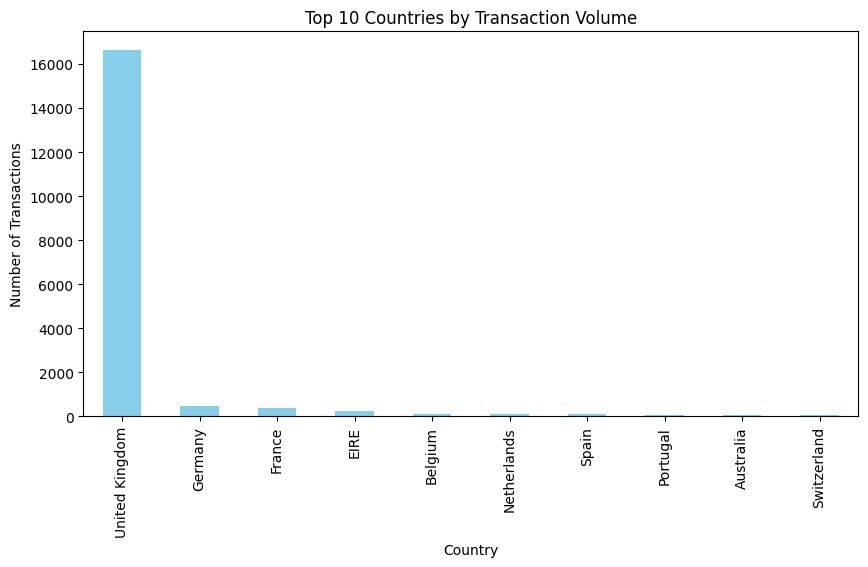

In [ ]:
import matplotlib.pyplot as plt
# Transactions by Country
country_sales = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)
plt.figure(figsize=(10,5))
country_sales.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Countries by Transaction Volume')
plt.ylabel('Number of Transactions')
plt.show()

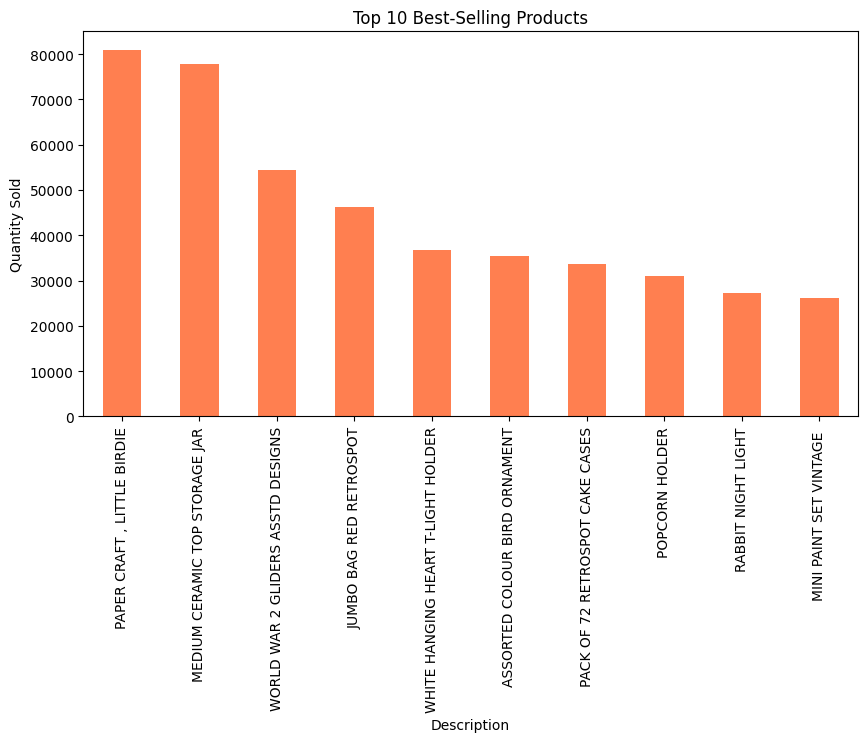

In [ ]:
# Top Selling Products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
top_products.plot(kind='bar', color='coral')
plt.title('Top 10 Best-Selling Products')
plt.ylabel('Quantity Sold')
plt.show()


/tmp/ipython-input-736030632.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum().plot(figsize=(10,5), color='teal')


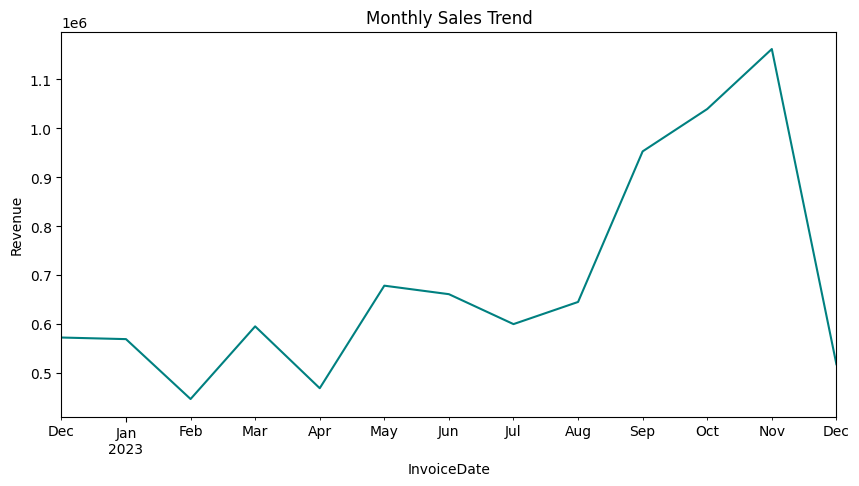

In [ ]:
# Monthly sales trend
df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum().plot(figsize=(10,5), color='teal')
plt.title('Monthly Sales Trend')
plt.ylabel('Revenue')
plt.show()


RFM Analysis

In [ ]:
# Reference date = day after the last purchase
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


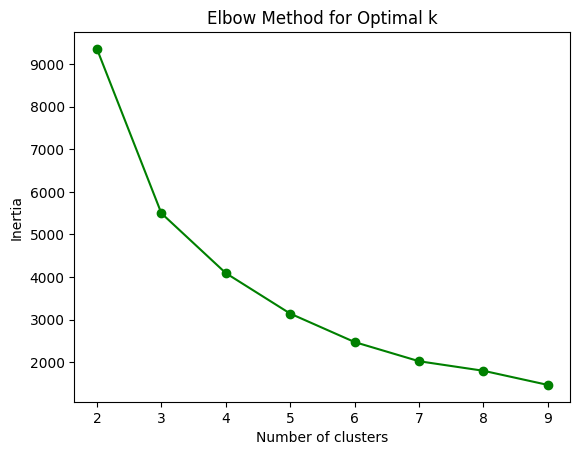

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# Normalize RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Determine optimal K using Elbow Method
inertia = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2,10), inertia, marker='o', color='green')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Fit KMeans with chosen cluster count (e.g. 4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Evaluate silhouette score
score = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"Silhouette Score: {score:.3f}")

rfm.groupby('Cluster').mean()

Silhouette Score: 0.616


,Recency,Frequency,Monetary
Cluster,,,
0,43.702685,3.682711,1359.049284
1,248.075914,1.552015,480.617480
2,7.384615,82.538462,127338.313846
3,15.500000,22.333333,12709.090490


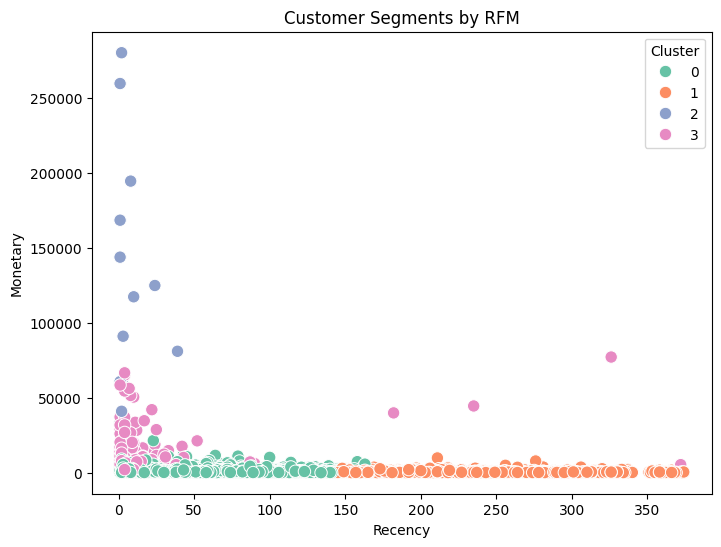

In [ ]:
import seaborn as sns
# Visualize clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2', s=80)
plt.title('Customer Segments by RFM')
plt.show()

Label Customer Segments

In [ ]:
# Assign human-readable labels
segment_labels = {
    0: 'High-Value',
    1: 'Regular',
    2: 'Occasional',
    3: 'At-Risk'
}
rfm['Segment'] = rfm['Cluster'].map(segment_labels)
rfm.head()


,Recency,Frequency,Monetary,Cluster,Segment
CustomerID,,,,,
12346.0,326,1,77183.60,3,At-Risk
12347.0,2,7,4310.00,0,High-Value
12348.0,75,4,1797.24,0,High-Value
12349.0,19,1,1757.55,0,High-Value
12350.0,310,1,334.40,1,Regular


In [ ]:
import pickle
import os

# Create the 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save KMeans and Scaler
pickle.dump(kmeans, open("models/kmeans_model.pkl", "wb"))
pickle.dump(scaler, open("models/scaler.pkl", "wb"))

Product Recommendation System

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# Create Customer–Product matrix
pivot = df.pivot_table(index='CustomerID', columns='Description', values='Quantity', fill_value=0)

# Compute cosine similarity between products
similarity = cosine_similarity(pivot.T)
similarity_df = pd.DataFrame(similarity, index=pivot.columns, columns=pivot.columns)

In [ ]:
# Recommendation function
def recommend(product_name, n=5):
    if product_name not in similarity_df.columns:
        return "❌ Product not found in database."
    similar_items = similarity_df[product_name].sort_values(ascending=False)[1:n+1]
    return similar_items.index.tolist()

# Example usage
recommend("WHITE HANGING HEART T-LIGHT HOLDER")


['GIN + TONIC DIET METAL SIGN',
 'TEA TIME TEA TOWELS ',
 'FAIRY CAKE FLANNEL ASSORTED COLOUR',
 'DOORMAT FAIRY CAKE',
 'RED HANGING HEART T-LIGHT HOLDER']

In [ ]:
pickle.dump(similarity_df, open("models/product_similarity.pkl", "wb"))


In [ ]:
print("RFM Segmentation Summary:")
display(rfm.reset_index().groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'CustomerCount'}))

RFM Segmentation Summary:


,Recency,Frequency,Monetary,CustomerCount
Segment,,,,
At-Risk,15.500000,22.333333,12709.090490,204
High-Value,43.702685,3.682711,1359.049284,3054
Occasional,7.384615,82.538462,127338.313846,13
Regular,248.075914,1.552015,480.617480,1067


In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.9 MB/s eta 0:00:00


In [ ]:
%%writefile Shopper_Spectrum.py
import streamlit as st

st.title("Shopper Spectrum")


Overwriting Shopper_Spectrum.py


In [ ]:
# ==========================================================
# 🛒 Shopper Spectrum: Streamlit App
# ==========================================================

import streamlit as st
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# ==========================================================
# 🎨 Streamlit Page Configuration
# ==========================================================
st.set_page_config(
    page_title="Shopper Spectrum",
    page_icon="🛒",
    layout="wide"
)

st.title("🛍 Shopper Spectrum: Customer Segmentation & Product Recommendations")

st.markdown("""
Welcome to **Shopper Spectrum**, an interactive E-commerce analytics tool for:
- 🎯 Customer segmentation using **RFM (Recency, Frequency, Monetary)** analysis
- 🤝 Personalized product recommendations using **Collaborative Filtering**
""")

# ==========================================================
# 📦 Load Models & Data
# ==========================================================
@st.cache_resource
def load_models():
    kmeans = pickle.load(open("models/kmeans_model.pkl", "rb"))
    scaler = pickle.load(open("models/scaler.pkl", "rb"))
    similarity_df = pickle.load(open("models/product_similarity.pkl", "rb"))
    return kmeans, scaler, similarity_df

try:
    kmeans, scaler, similarity_df = load_models()
    model_loaded = True
except Exception as e:
    st.error(f"⚠️ Model files not found or corrupted: {e}")
    model_loaded = False

# ==========================================================
# 🧮 Helper Functions
# ==========================================================
def predict_cluster(recency, frequency, monetary):
    """Predicts the customer cluster based on RFM values"""
    if not model_loaded:
        return "Model not loaded"
    input_data = [[recency, frequency, monetary]]
    scaled = scaler.transform(input_data)
    cluster = kmeans.predict(scaled)[0]
    return cluster

def recommend_product(product_name, n=5):
    """Recommends top N similar products"""
    if product_name not in similarity_df.columns:
        return None
    similar_items = similarity_df[product_name].sort_values(ascending=False)[1:n+1]
    return list(similar_items.index)

# ==========================================================
# 📊 Tabs: Customer Segmentation | Product Recommendation
# ==========================================================
tab1, tab2 = st.tabs(["🎯 Customer Segmentation", "🛒 Product Recommendations"])

# ==========================================================
# TAB 1: Customer Segmentation
# ==========================================================
with tab1:
    st.subheader("🎯 Predict Customer Segment Using RFM Scores")

    col1, col2, col3 = st.columns(3)

    with col1:
        recency = st.number_input("🕒 Recency (days since last purchase)", min_value=1, max_value=365, value=60)
    with col2:
        frequency = st.number_input("🔁 Frequency (number of purchases)", min_value=1, max_value=100, value=10)
    with col3:
        monetary = st.number_input("💰 Monetary (total spend)", min_value=1.0, max_value=50000.0, value=1000.0)

    if st.button("Predict Segment"):
        cluster = predict_cluster(recency, frequency, monetary)
        segment_labels = {
            0: 'High-Value 💎',
            1: 'Regular 😊',
            2: 'Occasional 🛍️',
            3: 'At-Risk ⚠️'
        }
        segment_name = segment_labels.get(cluster, f"Cluster {cluster}")
        st.success(f"**Predicted Segment:** {segment_name}")

        st.markdown("""
        **Segment Insights:**
        - 💎 *High-Value:* Loyal, frequent, and high spenders
        - 😊 *Regular:* Consistent but not top-tier spenders
        - 🛍️ *Occasional:* Low frequency and lower spending
        - ⚠️ *At-Risk:* Haven’t purchased in a while
        """)

# ==========================================================
# TAB 2: Product Recommendation
# ==========================================================
with tab2:
    st.subheader("🛒 Product Recommendations")

    product_name = st.text_input("Enter a Product Name (exact match)")

    if st.button("Get Recommendations"):
        if not model_loaded:
            st.error("⚠️ Recommendation model not loaded.")
        elif product_name.strip() == "":
            st.warning("Please enter a product name.")
        else:
            recommendations = recommend_product(product_name)
            if recommendations is None:
                st.error("❌ Product not found in the database. Try another name.")
            else:
                st.success(f"Top {len(recommendations)} Similar Products:")
                for i, rec in enumerate(recommendations, start=1):
                    st.write(f"{i}. {rec}")

# ==========================================================
# 📘 Footer
# ==========================================================
st.markdown("---")
st.caption("Developed by [Your Name] | Shopper Spectrum © 2025 | Powered by Streamlit + Scikit-Learn")

2025-11-15 11:42:12.963 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 11:42:12.966 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 11:42:12.967 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 11:42:12.969 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 11:42:12.971 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 11:42:12.973 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 11:42:12.975 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 11:42:12.981 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [ ]:
!streamlit run Shopper_Spectrum.py &>/content/logs.txt &

In [ ]:
!pip install streamlit cloudflared -q


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
!nohup streamlit run Shopper_Spectrum.py --server.port 8501 > streamlit.log 2>&1 &


In [ ]:
!cloudflared tunnel --url http://localhost:8501 --no-autoupdate > tunnel.log 2>&1 &


In [ ]:
!grep -o 'https://.*\.trycloudflare.com' tunnel.log | head -n 1


In [ ]:
!grep -o 'https://.*\.trycloudflare.com' nohup.out | head -n 1 | xargs -I {} echo "Your tunnel url {}"

grep: nohup.out: No such file or directory
